In [1]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Imagenes_confocal/Rata/C071112/'
nombre_foto = 'c3ack000'
x_calibracion = 4.5
ancho_corte = 3

How many peaks do you want to analyse? 1


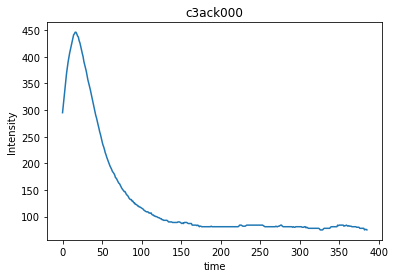

In [2]:
from PIL import Image             # funciones para cargar y manipular imágenes
import numpy as np                # funciones numéricas (arrays, matrices, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
%matplotlib inline
import cv2
from matplotlib.pyplot import subplots
from numpy import linspace
from scipy import interpolate
from scipy.signal import argrelextrema
import pandas as pd
from pylab import lstsq
from pylab import matrix
from pylab import exp
from math import log
import random
import  csv


if __name__ == '__main__' :
# Read image
    imag = cv2.imread(path + nombre_foto + ".tif")

    if imag is None:
        print("Check file path")
    else:
        cv2.imshow ('image', imag)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cantidad_picos = int(input ('How many peaks do you want to analyse?'))

    if cantidad_picos == 0:
        pass
    else:
        # Select ROI
        fromCenter = False
        showCrosshair = False
        r = cv2.selectROI(imag, fromCenter, showCrosshair)

        # Crop image
        imCrop = imag[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        up = int(r[1])
        down = int(r[1]+r[3])
        left = int(r[0])
        right = int(r[0]+r[2])

#########################
#- Creating a log file -#
log_path = path + 'logfile.txt'

with open(log_path, 'a') as my_file:
    my_file.write('selected area pict: '+ nombre_foto + '\n' +'up: ' + str(up) + '\n'+'down: ' + str(down) + '\n'+'left: ' + str(left) + '\n'+'right: ' + str(right) + '\n')

# Display cropped image
cv2.imshow("Image", imCrop)
cv2.waitKey(0)
cv2.destroyAllWindows()


################################
### PREPARACIÓN DE LA IMAGEN ###
################################

I = Image.open(path + nombre_foto + ".tif")
a=np.asarray(I,dtype=np.float32)  # convierte el objeto I en una matriz de tipo float32
Image.fromarray(a.astype(np.uint8)).save("prueba.jpg")  # primero convierte "a" a uint8, y luego a un objeto "imagen"


######################################################################################################
###HACE CORTES DE LA IMAGEN CADA INTERVALOS DE PIXELES Y LUEGO HACE UN HISTOGRAMA DE CADA INTERVALO###
######################################################################################################

## Genera una imagen en escala de grises con la que se trabaja

#             plt.figure()
#             plt.subplot(121)
#             plt.imshow(a,cmap='gray',interpolation='nearest')
#             plt.title('Imagen') 
a = cv2.bilateralFilter(a,20,300,300)

## Corta en porciones la imagen haciendo un histograma de cada una
x_data = np.asarray(range(up,down),dtype=np.float64)
list_img_row = []

whole_cell_SI = Image.fromarray(a[up:down, left:right].astype(np.uint8))
whole_cell_data = np.sum(whole_cell_SI,axis=1).tolist()
for i in range (left, right, ancho_corte):
    #recorte de la imagen en los límites del objeto
    seleccion=a[up:down,i:i + ancho_corte]
    #análisis de cada franja
    SI = Image.fromarray(seleccion.astype(np.uint8))
    img_row_sum = np.sum(SI,axis=1).tolist() #lista de datos del histograma
    list_img_row.append (img_row_sum)
#gráfico de cada franja
#             plt.subplot(122)
#             plt.imshow(seleccion,cmap='gray',interpolation='nearest')
#             plt.title('Subframe') 
#             plt.show()
#gráfico de histograma
plt.plot(img_row_sum)
plt.title(nombre_foto)
plt.xlabel("time")
plt.ylabel("Intensity")
plt.savefig('img_row_sum')
plt.show()

In [3]:
# Función que da la posición de los picos máximos

min_distancia = input ('Time between peaks?')
def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=min_distancia)
    kk = list(indexes)
    tiempos = []
    intensidades = []
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos.append (j)
            intensidades.append (vector[j])
    return tiempos,intensidades

# Aplico la función sobre los datos de la célula entera, y devuelve valores de tiempos e intensidades de los máximos


whole_cell_picos = maximo_peak (whole_cell_data)
whole_cell_tiempos_maximos = whole_cell_picos [0]
whole_cell_intensidades_maximos = whole_cell_picos [1]

cantidad_total_picos = int (len(whole_cell_picos[0]))                             
Columns = ['Transient_'+ str(x) for x in range(0, cantidad_total_picos)]
wc = pd.DataFrame([whole_cell_tiempos_maximos,whole_cell_intensidades_maximos], columns = Columns)

# Aplico la función sobre los datos, y devuelve valores de tiempos e intensidades de los máximos

datos_tiempos = {}
datos_intensidades = {}  

for i in range (0,len(list_img_row)):

    picos = maximo_peak (list_img_row[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]

df_tiempos = pd.DataFrame(list(datos_tiempos.items()),columns = ['Rows','Picos'])
df_intensidades = pd.DataFrame(list(datos_intensidades.items()),columns = ['Rows','Picos'])
Columns = ['Pico_'+ str(x) for x in range(0, cantidad_total_picos)]
tiempos_maximos = pd.DataFrame(df_tiempos.Picos.tolist(), columns=Columns)
intensidades_maximas = pd.DataFrame(df_intensidades.Picos.tolist(), columns=Columns)

Time between peaks? 400


### MEDIDA DE LA VELOCIDAD DE PROPAGACIÓN DE WAVES

-1.522350195724179 375.41041854862993


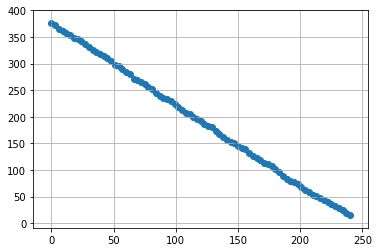

In [5]:
import numpy as np
import matplotlib.pyplot as plt

wp = pd.DataFrame()
wp ['tiempo']= tiempos_maximos ['Pico_0']
wp ['distancia'] = range (0,ancho_corte*len (tiempos_maximos ['Pico_0']),ancho_corte)

x = list(wp ['distancia'])
y = list(wp ['tiempo'])

(m, b) = np.polyfit(x, y, 1)
print(m, b)

yp = np.polyval([m, b], x)
plt.plot(x, yp)
plt.grid(True)
plt.scatter(x,y)
plt.savefig(path + 'wave_prop.png')